# Deep Neural Network training to retrieve Normalized-Gamma Size Distribution (NGSD) parameters

---

## Imports

In [1]:
import xarray as xr
import datatree
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from scipy.special import gamma
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from collections import Counter
from dask.distributed import Client, LocalCluster
from matplotlib.colors import ListedColormap

2024-03-05 10:49:05.649246: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 10:49:06.305308: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# setting up the Seaborne style including figure  dpi
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set(style='white', font_scale=0.9)
sns.set_style("ticks")

### Local Cluster

Let's spin up our `Dask` local cluster

In [3]:
cluster = LocalCluster()  
# display(cluster)

## Data

CAMP2Ex dataset is store in Analysis-Ready Cloud-Optimized (ARCO) format ([Abernathey et al. 2021](https://ieeexplore.ieee.org/document/9354557)) using [Xarray-Datatree](https://xarray-datatree.readthedocs.io/en/latest/) data model that allows us to have both Learjet and P3B datasets in one `datatree`. Results from [K-means cluster](1.K-means-psd.ipynb) are also loaded into a `Pandas.Dataframe`

In [4]:
path_data = '../data/camp2ex_dtree.zarr'
dt_camp2ex = datatree.open_datatree(path_data, engine='zarr', consolidated=True)
path_kmeans = '../data/df_cluster.parquet'
df = pd.read_parquet(path_kmeans)

## Deep Neural Network Training

<img src="../images/DNN.svg" width=500 alt="DNN"></img>

In [5]:
X = df[['dbz_t_ku', 'dfr', 'temp', 'Att_ka', 'log10_nw', 'dm', 'new_mu']]
Y = df[['dm_class', 'r', 'kmeans', 'time']]

In [6]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X.values)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'new_mu']].values)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y.values, test_size=0.25, random_state=40, stratify=df.kmeans_6)
X_train.shape

(6532, 7)

In [8]:
def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(8, activation="relu",
                                    input_shape=[X_train.shape[1]-3]))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(8, activation="relu"))
    model.add(tf.keras.layers.Dense(3))
    optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
    model.compile(loss="mse",
              optimizer=optimizer,
              metrics=['mae', 'mse'])
    return model

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

model = build_model()

2024-03-05 10:49:08.857649: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-05 10:49:08.885178: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train[:, 0].astype(float))
print(f"Training target statistics: {Counter(y_res)}")
print(f"Testing target statistics: {Counter(y_test[:, 0])}")

Training target statistics: Counter({1.0: 4411, 0.0: 4411})
Testing target statistics: Counter({0: 1492, 1: 686})


In [10]:
EPOCHS = 500
history = model.fit(X_res[:, :4], X_res[:, 4:],
                    validation_data=(X_test[:, :4], X_test[:, 4:]),
                    epochs=EPOCHS,
                    batch_size=32, verbose=0,
                    callbacks=[PrintDot(), early_stop])


....................................................................................................
....................................................................................................
............................................................................................

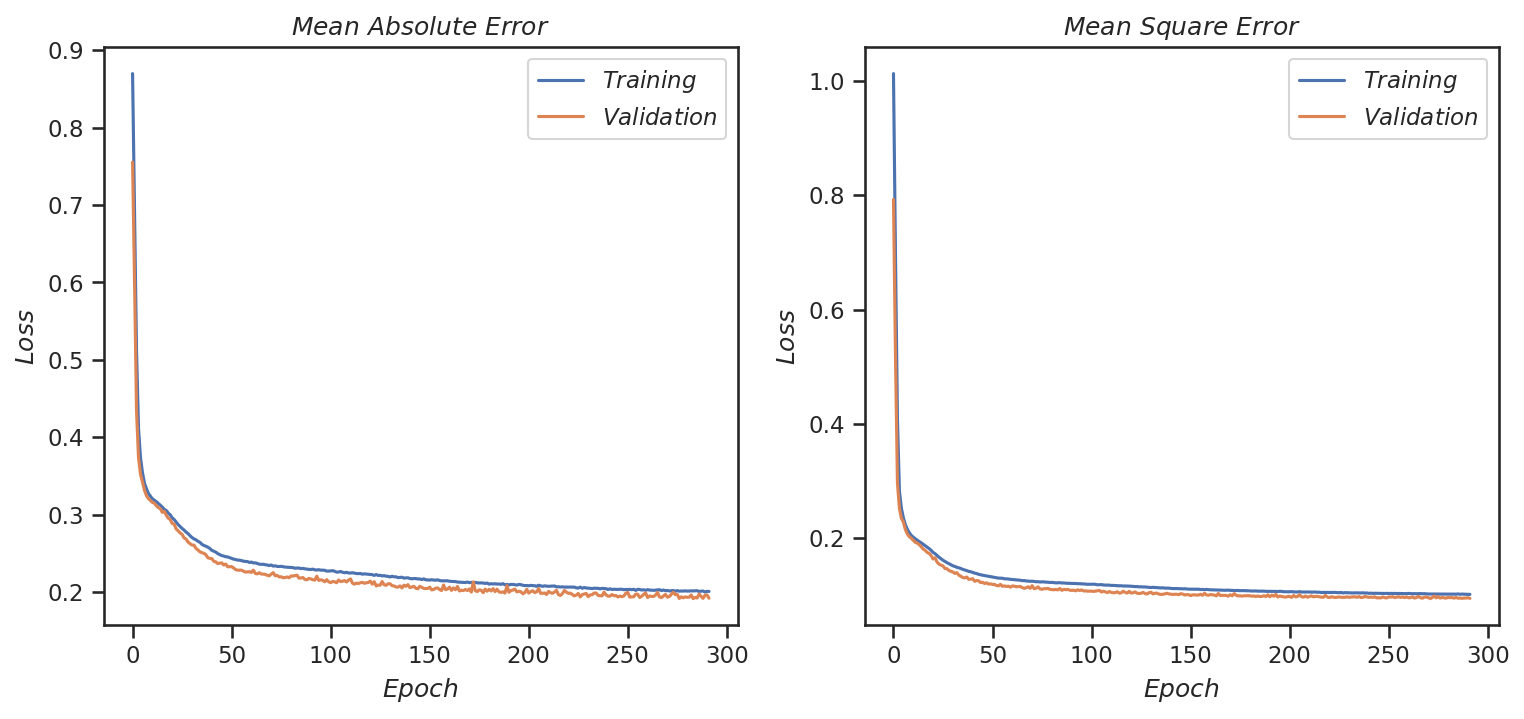

In [11]:
hist = pd.DataFrame(history.history)
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 5))
hist['epoch'] = history.epoch


ax.set_xlabel('$Epoch$')
ax.set_ylabel('$Loss$')
ax.set_title('$Mean \ Absolute \  Error$')
ax.plot(hist['epoch'], hist['mae'], label='$Training$')
try:
    ax.plot(hist['epoch'], hist['val_mae'], label='$Validation$')
except KeyError:
    pass
# plt.ylim([0,5])
ax.legend()

ax1.set_xlabel('$Epoch$')
ax1.set_ylabel("$Loss$")
ax1.set_title('$Mean \ Square \ Error$')
ax1.plot(hist['epoch'], hist['mse'],
         label='$Training$')
try:
    ax1.plot(hist['epoch'], hist['val_mse'],
              label='$Validation$')
except KeyError:
    pass
# plt.ylim([0,3])
ax1.legend()
# plt.savefig("../results/loss.jpeg",  bbox_inches="tight")
plt.show()

In [12]:
yhat = model.predict(X_test[:, :4])
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 4:])

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [13]:
# defining the Colormap for each cluster identified
my_cmap6 = ListedColormap(sns.color_palette('deep', 6))
colors6 = my_cmap6(np.linspace(0,1,6))

In [14]:
def metrics_pd(x, xpred):
    xpred = xpred.astype(float)
    x = x.astype(float)
    x = x[(~np.isnan(xpred)) & (~np.isinf(xpred))]
    xpred = xpred[(~np.isnan(xpred)) & (~np.isinf(xpred))]
    rmse = np.sqrt(np.sum((xpred - x) ** 2 / len(x)))
    mae = np.sum(np.abs(xpred - x)) / len(x)
    corr = np.corrcoef(x, xpred)**2.
    return rmse, mae, corr[0, 1]

In [15]:
n_c = 6

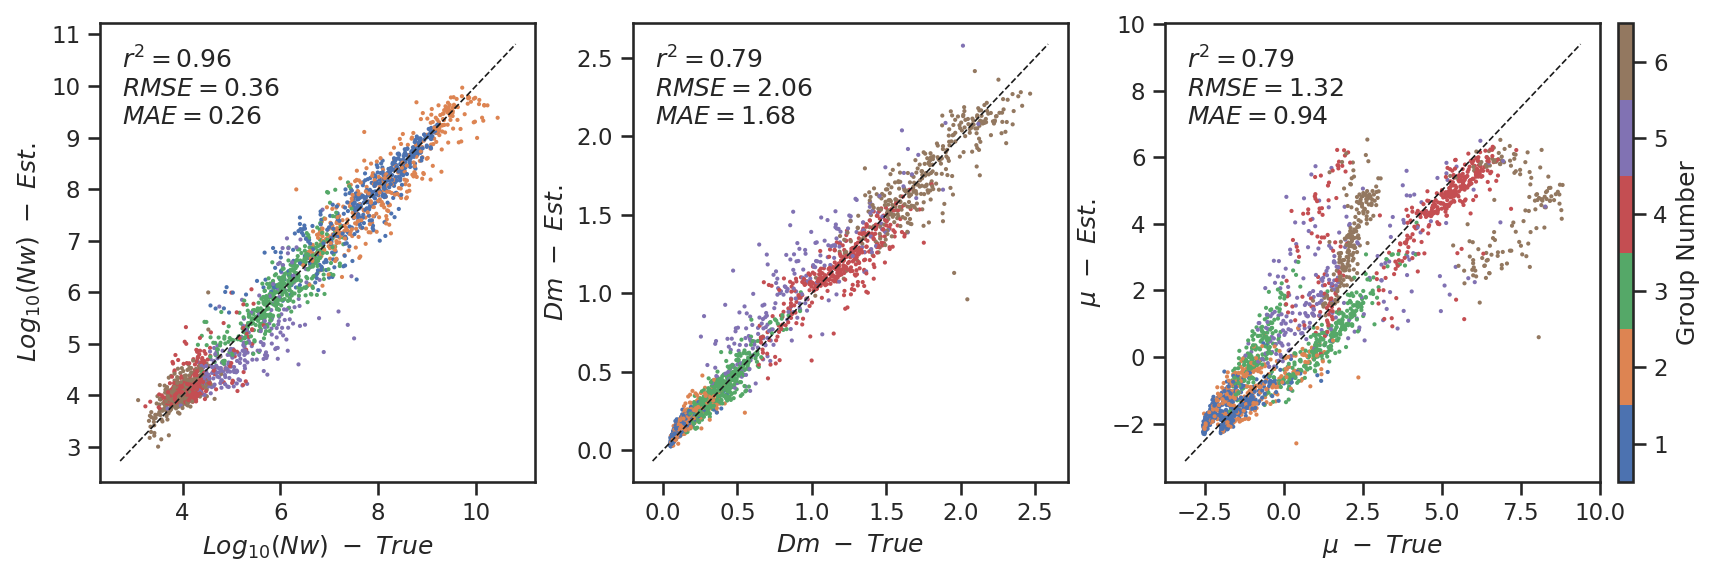

In [16]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4))
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test[:, -2], cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test[:, -2], cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test[:, -2], cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()

cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = (np.arange(n_c) + 0.5) * (n_c - 1) / n_c + 1
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c + 1))